In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import scipy.stats as stat
import random
import diff_classifier.aws as aws
import diff_classifier.msd as msd
from diff_classifier.msd import binning, precision_weight, precision_averaging, plot_all_experiments
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [2]:
folder = '06_26_28_practice_tracking_tissue'
bucket = 'hpontes.data'
experiment = 'tissue' #Used for naming purposes. Should exclude XY and well information

vids = 2
to_track = []
wells = 1
frames = 651
fps = 100.02

In [3]:
slices = ["1", "2"]
for i in slices: 
    to_track.append('100nm_PS_PEG_vid_{}'.format(i)) #As per usual, use for loops to include all experiments

slices, bins, well_names = binning(to_track)
geoM2xy = {}
gSEM = {}
for sample_name in to_track:
    #aws.download_s3('{}/geomean_{}.csv'.format(folder, sample_name), 'geomean_{}.csv'.format(sample_name), bucket_name=bucket)
    #aws.download_s3('{}/geoSEM_{}.csv'.format(folder, sample_name), 'geoSEM_{}.csv'.format(sample_name), bucket_name=bucket)
    #geoM2xy[sample_name] = np.genfromtxt('geomean_{}.csv'.format(sample_name))
    #gSEM[sample_name] = np.genfromtxt('geoSEM_{}.csv'.format(sample_name))
    print(sample_name)
    msd_f = 'msd_{}.csv'.format(sample_name)
    aws.download_s3('{}/{}'.format(folder, msd_f), msd_f, bucket_name=bucket)
    try:
        geoM2xy[sample_name], gSEM[sample_name] = msd.gavg_MSDs(sample_name, umppx=0.16, fps=100.02,
                                                                upload=True, remote_folder=folder, bucket=bucket)
    except:
        geoM2xy[sample_name], gSEM[sample_name] = (np.nan*np.ones(frames), np.nan*np.ones(frames))

100nm_PS_PEG_vid_1
100nm_PS_PEG_vid_2


In [7]:
well_names

['100nm_5k_PEG_W0', '100nm_5k_PEG_W1', '100nm_5k_PEG_W2', '100nm_5k_PEG_W3']

In [8]:
weights = precision_weight(to_track, gSEM)
geo, gS = precision_averaging(to_track, geoM2xy, gSEM, weights, bucket=bucket, folder=folder, experiment=experiment)

'06_26_28_practice_tracking_tissue'

In [ ]:
geo_slices = {}
gSEM_slices = {}

w_slices = {}
wo_slices = {}

for key in bins:
    wo_slices[key] = precision_weight(bins[key], gSEM)
    geo_slices[key], gSEM_slices[key] = precision_averaging(bins[key], geoM2xy, gSEM, wo_slices[key]) 

weights = precision_weight(well_names, gSEM_slices)
geo, gS = precision_averaging(well_names, geo_slices, gSEM_slices, weights, bucket=bucket, folder=folder, experiment=experiment)

Text(0,0.5,'Mean Squared Displacement ($\\mu$m$^2$/s)')

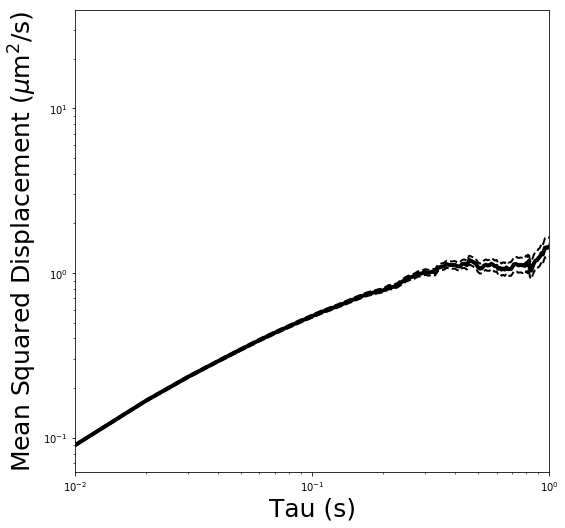

In [5]:
#Plot as desired. Can also modift to include multiple datasets as needed. Yay!

fig = plt.figure(figsize=(8.5, 8.5))
y_range = 1
plt.xlim(10**-2, 10**0)
#plt.ylim(0, y_range)

x = np.linspace(0, frames-1, frames)/fps

plt.loglog(x, np.exp(geo), 'k', linewidth=4)
plt.loglog(x, np.exp(geo - 1.96*gS), 'k--', linewidth=2)
plt.loglog(x, np.exp(geo + 1.96*gS), 'k--', linewidth=2)

plt.xlabel('Tau (s)', fontsize=25)
plt.ylabel(r'Mean Squared Displacement ($\mu$m$^2$/s)', fontsize=25)

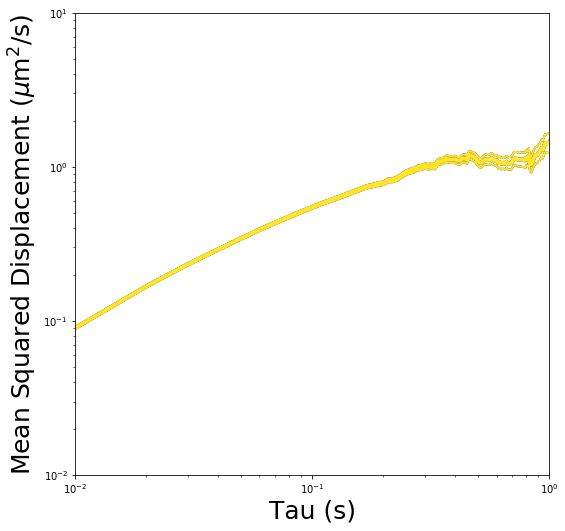

In [6]:
to_plot_f = ['tissue', 'tissue']
plot_all_experiments(to_plot_f, bucket=bucket, folder=folder, yr=(10**-2, 10**1))